In [1]:
import pandas as pd
import numpy as np

import keras
from keras import layers
from keras import models
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator, image
from keras.applications import mobilenet_v2
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from keras import backend as K

import math
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import glob
import os
from pathlib import Path
import shutil

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Basic CNN (2 and 4 classes)
In this notebook, we will use a basic convolutional neural network to try and classify up to 4 species of birds.

In [4]:
root = '/content/drive/MyDrive/Education/Data Science/6. Deep Learning/data'

In [5]:
train_dir = root + '/train'
validation_dir = root + '/valid'
test_dir = root + '/test'

In [6]:
# Based on https://stackoverflow.com/questions/60448904/use-only-n-images-using-imagedatagenerator-from-each-class but for number of species

# This function lets us loop through the data until we reach the desired number of classes
def limit_data(data_dir,n=5):
    a=[]
    for i, directory in enumerate(os.listdir(data_dir)):
      if directory[0] != '.':
          for species in os.listdir(data_dir+'/'+directory):
              a.append((f'{data_dir}/{directory}/{species}',directory))
          if i == n - 1: return pd.DataFrame(a,columns=['filename','class'])
      else: n += 1


In [7]:
train_data = limit_data(train_dir, 2)

In [8]:
# Looping through the training data will collect different species than looping through the valid and test data so we need a function that will collect the proper valid/test data
def get_valid_test_data(df, data_dir):
  a = []
  classes = df['class'].unique()
  for class_ in classes:
    if class_[0] != '.':
      directory =  data_dir + '/' + class_
      for species in os.listdir(directory):
        a.append((f'{directory}/{species}',class_))
  return pd.DataFrame(a, columns=['filename','class'])


In [9]:
valid_data = get_valid_test_data(train_data, validation_dir)

In [10]:
test_data = get_valid_test_data(train_data, test_dir)

We will only go up to 4 classes for this model so let's take a look at some sample pictures.

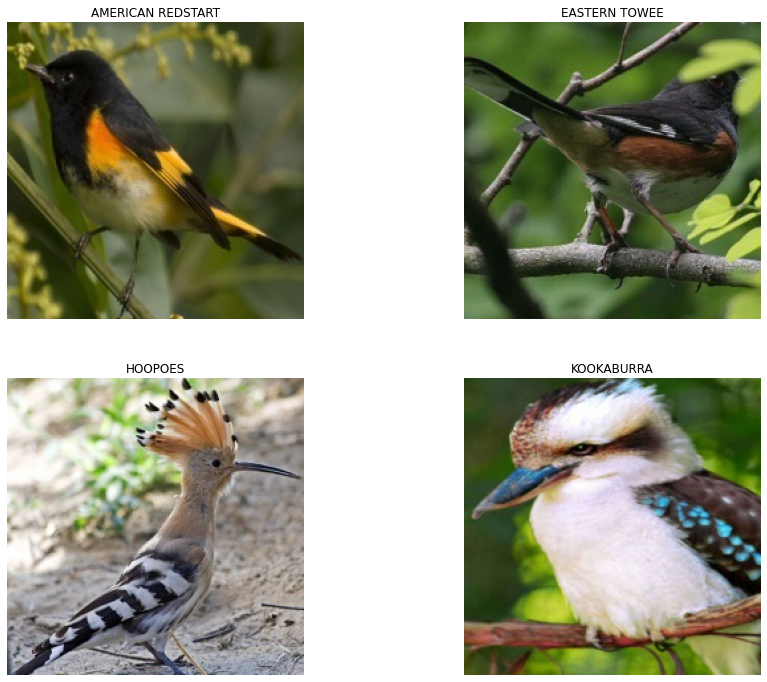

In [11]:
train = limit_data(train_dir, 4)
train = train.groupby('class')['filename'].first()

fig, ax = plt.subplots(2, 2, figsize=(15,12))
for i, path in enumerate(train):
  plt.subplot(2,2,i + 1)
  img = Image.open(path)
  plt.imshow(img)
  img.close()
  plt.axis('off')
  plt.title(list(train.index)[i])

We now have functions we can use to assemble file paths and classes to a dataframe which we will pass to keras.flow_from_dataframe() method.

In [12]:
#@title

# https://github.com/caroshi/neuralnetworks_art-periods-classification/blob/master/modeling/threeclass--cnn.ipynb

def create_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape=(224, 224, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(100, activation='relu'))

  return model

#### We will add the below commented layers later once we know the number of classes we want to use.

# model.add(layers.Dense(train_data['class'].nunique(), activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam', metrics=['acc'])

In [13]:
#@title

def run_model(**params):

  # collect data
  train_data = limit_data(train_dir, params['num_species'])
  valid_data = get_valid_test_data(train_data, validation_dir)
  test_data = get_valid_test_data(train_data, test_dir)

# create data generators to including augmentation
  # https://github.com/caroshi/neuralnetworks_art-periods-classification/blob/master/modeling/threeclass--cnn.ipynb
  train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=params['horizontal_flip'], rotation_range=params['rotation_range'])
  val_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=params['horizontal_flip'], rotation_range=params['rotation_range'])

  train_generator = train_datagen.flow_from_dataframe(
          train_data,
          directory = None,
          x_col = 'filename',
          y_col = 'class',
          target_size=(244, 244),
          batch_size=params['train_batch_size'],
          class_mode='categorical')

  validation_generator = val_datagen.flow_from_dataframe(
          valid_data,
          directory = None,
          x_col = 'filename',
          y_col = 'class',
          target_size=(244, 244),
          batch_size=params['valid_batch_size'],
          class_mode='categorical')
  
  # Finish building model by adding a final layer with the number of nodes corresponding to number of bird species
  model = params['model']
  model.add(layers.Dense(train_data['class'].nunique(), activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
  model.summary()

  # Set step size
  # https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1
  STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
  STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
  history = params['model'].fit_generator(generator=train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=validation_generator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=params['num_epochs'])
  
  # Save model
  num_species = params['num_species']
  augmented = str(bool(params['horizontal_flip']))
  model.save(root + f'/num_species_{num_species}_aug_{augmented}.h5')
  
  # https://github.com/caroshi/neuralnetworks_art-periods-classification/blob/master/modeling/threeclass--cnn.ipynb
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure(figsize=(10,7))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy', fontsize=18)
  plt.xlabel('Number of epochs', fontsize=14)
  plt.ylabel('Accuracy', fontsize=14)
  plt.legend()

  plt.figure(figsize=(10,7))
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss', fontsize=18)
  plt.xlabel('Number of epochs', fontsize=14)
  plt.ylabel('Loss', fontsize=14)
  plt.legend()

  plt.show()

In [14]:
#@title

# This function resets the model weights so we don't have to rebuild it from scratch each time.
# https://stackoverflow.com/questions/63435679/reset-all-weights-of-keras-model#63439595
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if hasattr(model.layers[ix], 'kernel_initializer') and \
              hasattr(model.layers[ix], 'bias_initializer'):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

In [ ]:
params = {}
params['num_species'] = 2
params['num_epochs'] = 10
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees
# reset_weights(model)

Found 264 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 121, 121, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 59, 59, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 128)       73856     
   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
8/8 [==============================] - 40s 4s/step - loss: 0.9069 - acc: 0.4744 - val_loss: 0.6914 - val_acc: 0.6000
Epoch 2/10
8/8 [==============================] - 1s 136ms/step - loss: 0.6795 - acc: 0.6111 - val_loss: 0.6586 - val_acc: 0.8000
Epoch 3/10
8/8 [==============================] - 1s 136ms/step - loss: 0.5646 - acc: 0.7607 - val_loss: 0.4847 - val_acc: 0.8000
Epoch 4/10
8/8 [==============================] - 1s 154ms/step - loss: 0.3551 - acc: 0.8504 - val_loss: 0.4505 - val_acc: 0.7000
Epoch 5/10
8/8 [==============================] - 1s 144ms/step - loss: 0.2340 - acc: 0.9060 - val_loss: 0.4082 - val_acc: 0.8000
Epoch 6/10
8/8 [==============================] - 1s 136ms/step - loss: 0.1629 - acc: 0.9444 - val_loss: 0.5212 - val_acc: 0.8000
Epoch 7/10
8/8 [==============================] - 1s 135ms/step - loss: 0.2034 - acc: 0.9145 - val_loss: 0.3174 - val_acc: 0.8000
Epoch 8/10
8/8 [==============================] - 1s 155ms/step - loss: 0.1505 - acc: 0.9316

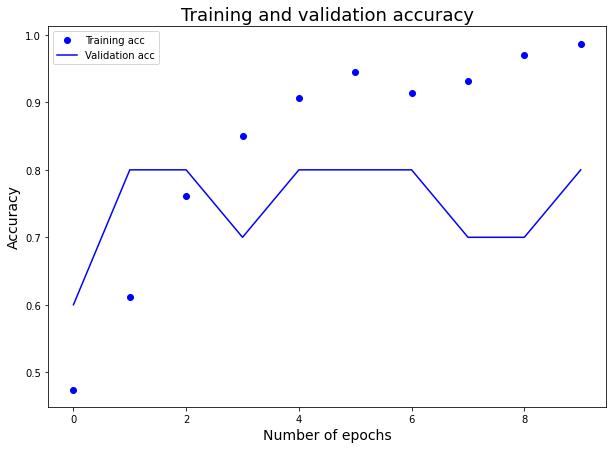

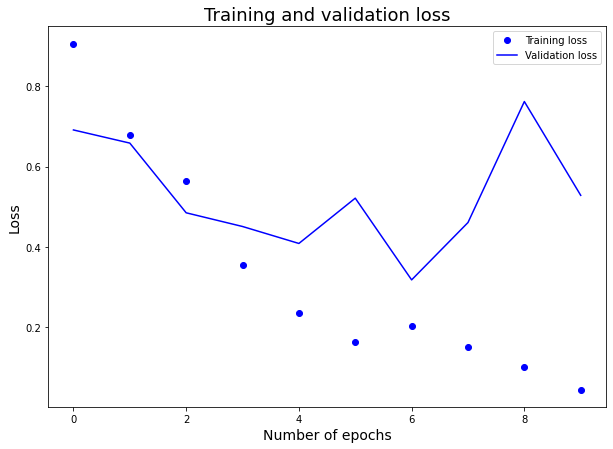

In [ ]:
run_model(**params)

The first results are not very good. Only 80% accuracy for validation. Let's repeat but increase the number of epochs.

In [ ]:
params = {}
params['num_species'] = 2
params['num_epochs'] = 30
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 264 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 121, 121, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 119, 119, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 59, 59, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 57, 57, 128)       73856     
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
8/8 [==============================] - 3s 313ms/step - loss: 0.7266 - acc: 0.5641 - val_loss: 0.6686 - val_acc: 0.7000
Epoch 2/30
8/8 [==============================] - 2s 192ms/step - loss: 0.5390 - acc: 0.7778 - val_loss: 0.5917 - val_acc: 0.8000
Epoch 3/30
8/8 [==============================] - 1s 150ms/step - loss: 0.2943 - acc: 0.9042 - val_loss: 0.4843 - val_acc: 0.8000
Epoch 4/30
8/8 [==============================] - 1s 135ms/step - loss: 0.1884 - acc: 0.9188 - val_loss: 0.4206 - val_acc: 0.7000
Epoch 5/30
8/8 [==============================] - 1s 154ms/step - loss: 0.2443 - acc: 0.9017 - val_loss: 0.5634 - val_acc: 0.7000
Epoch 6/30
8/8 [==============================] - 1s 149ms/step - loss: 0.2274 - acc: 0.9145 - val_loss: 0.3724 - val_acc: 0.8000
Epoch 7/30
8/8 [==============================] - 1s 139ms/step - loss: 0.1782 - acc: 0.9188 - val_loss: 0.5903 - val_acc: 0.7000
Epoch 8/30
8/8 [==============================] - 1s 157ms/step - loss: 0.0895 - acc: 0.97

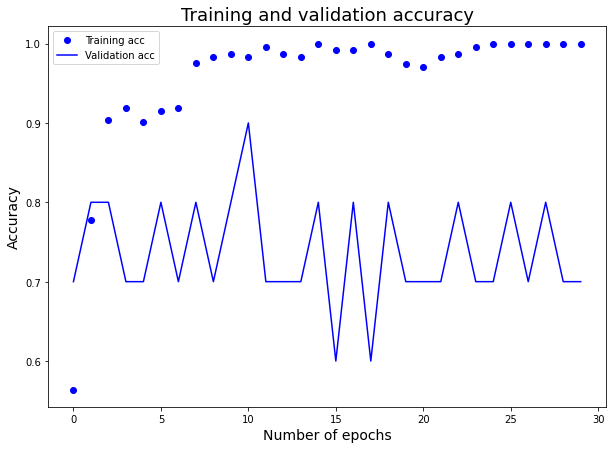

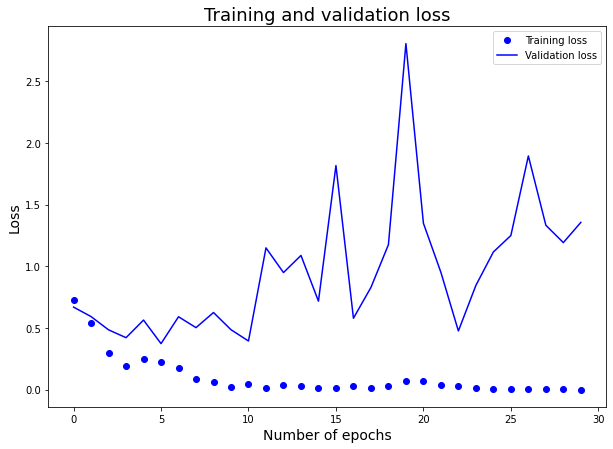

In [ ]:
run_model(**params)

The results show that by adding epochs, we can perfectly fit the training data but max out the improvement in validation. Let's try adding in some image augmentation by introducing horizontal flipping to increase the number of training images and rotating.

In [ ]:
params = {}
params['num_species'] = 2
params['num_epochs'] = 30
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['model'] = create_model()
params['horizontal_flip'] = True
params['rotation_range'] = 45 # set between 0 and 45 degrees

Found 264 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 121, 121, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 119, 119, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 59, 59, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 57, 57, 128)       73856     
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
8/8 [==============================] - 5s 525ms/step - loss: 0.9571 - acc: 0.5385 - val_loss: 0.6911 - val_acc: 0.5000
Epoch 2/30
8/8 [==============================] - 4s 469ms/step - loss: 0.6833 - acc: 0.5667 - val_loss: 0.6913 - val_acc: 0.5000
Epoch 3/30
8/8 [==============================] - 4s 456ms/step - loss: 0.5757 - acc: 0.7735 - val_loss: 0.5981 - val_acc: 0.8000
Epoch 4/30
8/8 [==============================] - 4s 455ms/step - loss: 0.4450 - acc: 0.8034 - val_loss: 0.5143 - val_acc: 0.7000
Epoch 5/30
8/8 [==============================] - 4s 454ms/step - loss: 0.3105 - acc: 0.8761 - val_loss: 0.3790 - val_acc: 0.8000
Epoch 6/30
8/8 [==============================] - 4s 459ms/step - loss: 0.2293 - acc: 0.9103 - val_loss: 0.4582 - val_acc: 0.8000
Epoch 7/30
8/8 [==============================] - 4s 467ms/step - loss: 0.2055 - acc: 0.9274 - val_loss: 0.7091 - val_acc: 0.7000
Epoch 8/30
8/8 [==============================] - 4s 500ms/step - loss: 0.1931 - acc: 0.91

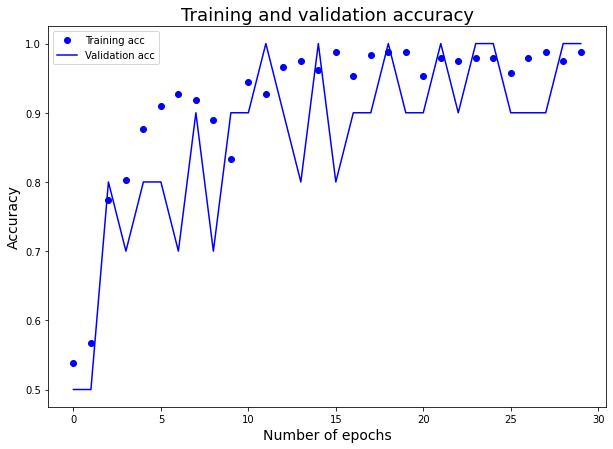

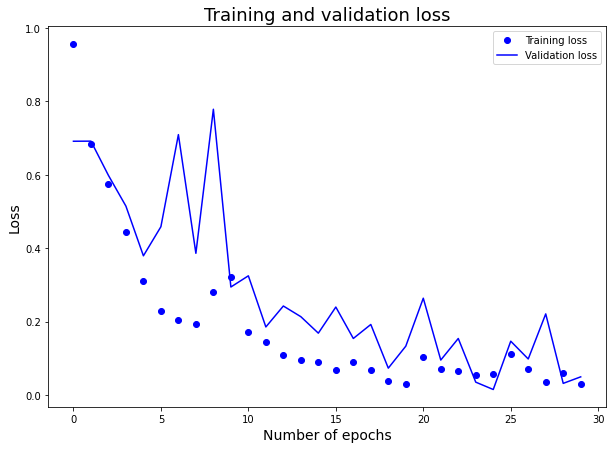

In [ ]:
run_model(**params)

Validation accuracy improves but still fluctuates a lot with number of epochs. Let's try 4 species and then think about regularizing.

In [ ]:
params = {}
params['num_species'] = 4
params['num_epochs'] = 30
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['model'] = create_model()
params['horizontal_flip'] = True
params['rotation_range'] = 45 # set between 0 and 45 degrees

Found 534 validated image filenames belonging to 4 classes.
Found 20 validated image filenames belonging to 4 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 121, 121, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 119, 119, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 59, 59, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 57, 57, 128)       73856     
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
17/17 [==============================] - 47s 3s/step - loss: 1.3628 - acc: 0.3353 - val_loss: 1.2543 - val_acc: 0.4500
Epoch 2/30
17/17 [==============================] - 8s 456ms/step - loss: 1.1508 - acc: 0.5258 - val_loss: 1.0443 - val_acc: 0.6000
Epoch 3/30
17/17 [==============================] - 8s 453ms/step - loss: 0.8318 - acc: 0.6706 - val_loss: 0.8513 - val_acc: 0.5500
Epoch 4/30
17/17 [==============================] - 8s 463ms/step - loss: 0.7426 - acc: 0.6845 - val_loss: 1.3932 - val_acc: 0.5000
Epoch 5/30
17/17 [==============================] - 8s 456ms/step - loss: 0.9026 - acc: 0.6647 - val_loss: 0.8140 - val_acc: 0.8000
Epoch 6/30
17/17 [==============================] - 8s 455ms/step - loss: 0.6736 - acc: 0.7361 - val_loss: 0.7438 - val_acc: 0.7000
Epoch 7/30
17/17 [==============================] - 8s 457ms/step - loss: 0.5521 - acc: 0.7897 - val_loss: 0.6105 - val_acc: 0.8000
Epoch 8/30
17/17 [==============================] - 8s 455ms/step - loss: 0.48

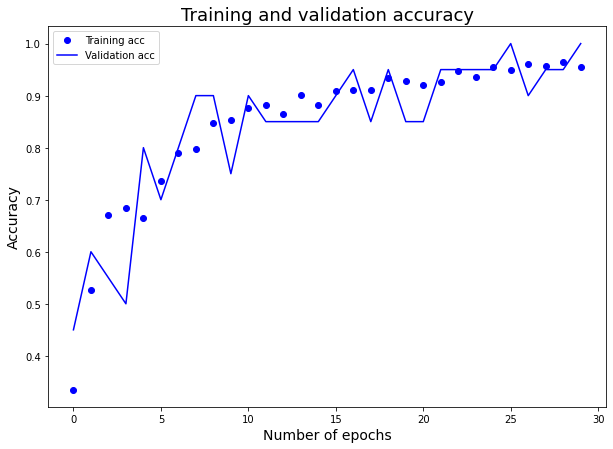

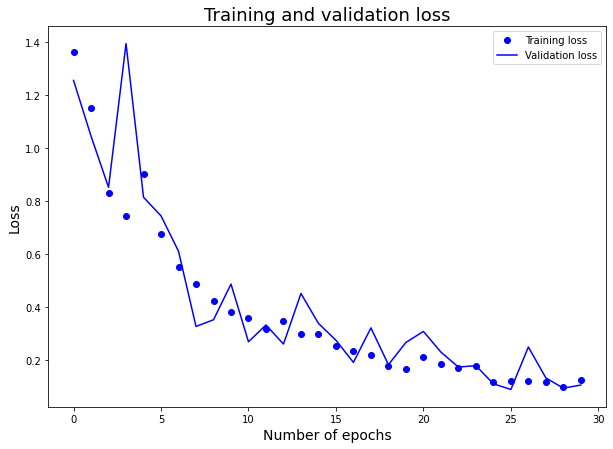

In [ ]:
run_model(**params)

In [ ]:
params = {}
params['num_species'] = 4
params['num_epochs'] = 30
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = 0 # set between 0 and 45 degrees

Found 534 validated image filenames belonging to 4 classes.
Found 20 validated image filenames belonging to 4 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 121, 121, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 119, 119, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 59, 59, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 57, 57, 128)       73856     
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
17/17 [==============================] - 3s 124ms/step - loss: 1.3932 - acc: 0.3175 - val_loss: 1.4176 - val_acc: 0.2500
Epoch 2/30
17/17 [==============================] - 2s 114ms/step - loss: 1.3229 - acc: 0.3671 - val_loss: 1.0728 - val_acc: 0.5000
Epoch 3/30
17/17 [==============================] - 2s 113ms/step - loss: 1.0681 - acc: 0.5456 - val_loss: 0.9579 - val_acc: 0.5500
Epoch 4/30
17/17 [==============================] - 2s 116ms/step - loss: 0.8180 - acc: 0.6607 - val_loss: 0.7071 - val_acc: 0.7000
Epoch 5/30
17/17 [==============================] - 2s 114ms/step - loss: 0.5524 - acc: 0.7956 - val_loss: 0.8364 - val_acc: 0.6500
Epoch 6/30
17/17 [==============================] - 2s 113ms/step - loss: 0.4325 - acc: 0.8591 - val_loss: 1.0334 - val_acc: 0.6500
Epoch 7/30
17/17 [==============================] - 2s 114ms/step - loss: 0.4681 - acc: 0.8135 - val_loss: 0.6057 - val_acc: 0.7500
Epoch 8/30
17/17 [==============================] - 2s 111ms/step - loss: 0.

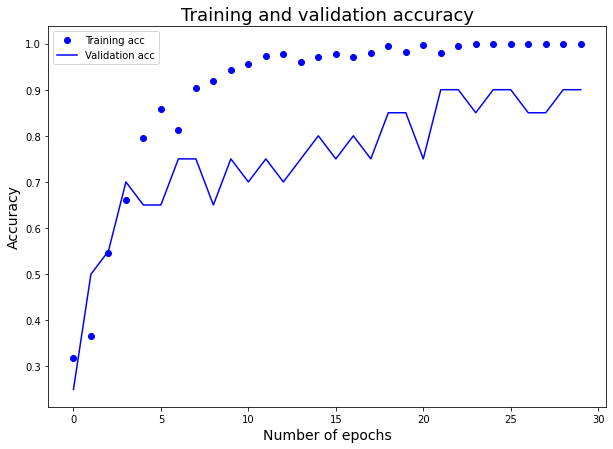

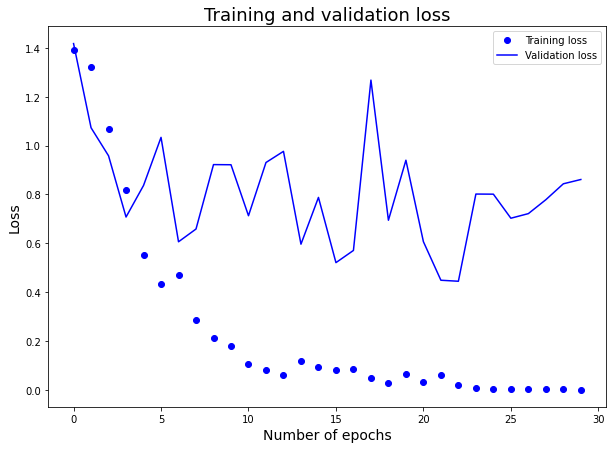

In [ ]:
run_model(**params)

# Plotting model

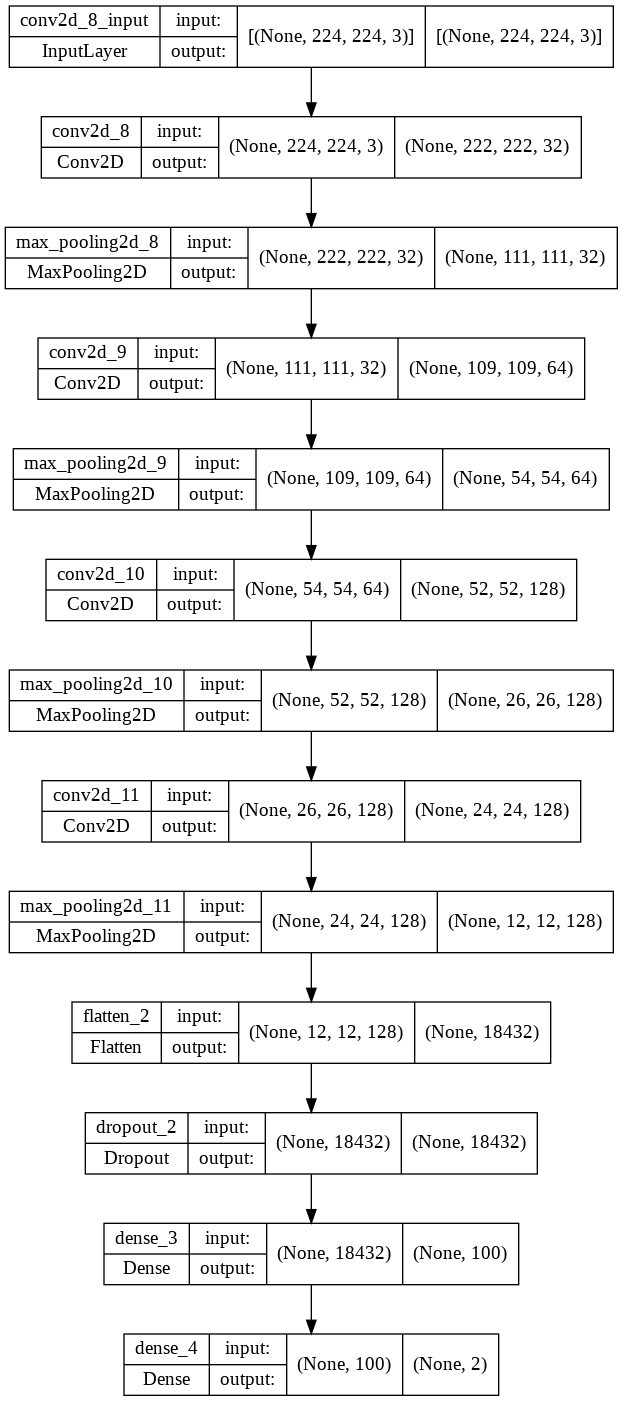

In [9]:
from tensorflow.keras.utils import plot_model
model = create_model()
model.add(layers.Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
plot_model(model, to_file='seq2seq_model_plot.png', show_shapes=True, show_layer_names=True)